# Rozwiązywanie układów równań liniowych
## Laboratorium 2 - Metody Obliczeniowe w Nauce i Technice

In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
from datetime import datetime

## Zadanie 1. Eliminacja Gaussa-Jordana.

In [2]:
# Gauss-Jordan elimination algorithm with partial pivoting
def gauss_jordan(A):
    n = len(A)
    m = len(A[0])
    h = k = 0

    while h < n and k < m:
        id_max = max([(abs(A[i][k]), i) for i in range(h, n)])[1]
        if A[id_max][k] == 0: k += 1
        else:
            A[[h, id_max]] = A[[id_max, h]]
            for i in range(h + 1, n):
                f = A[i][k] / A[h][k]
                A[i][k] = 0
                for j in range(k + 1, m): A[i][j] -= f * A[h][j]
            h += 1
            k += 1
            
    return A


# Backward substitution
def backward_substitution(A):
    n = len(A)
    m = len(A[0])
    
    for h in range(n - 1, -1, -1):
        A[h][m - 1] *= 1 / A[h][h]
        A[h][h] = 1
        for i in range(h - 1, -1, -1):
            f = A[i][h]
            A[i][h] = 0
            for j in range(h + 1, m): A[i][j] -= f * A[h][j]
            
    return A


# Linear solver
def lin_solve(A, y):
    n = len(A)
    Ay = np.hstack((A, np.array([[x] for x in y])))
    Ay = backward_substitution(gauss_jordan(Ay))
    
    return np.array([x[n] for x in Ay])

In [ ]:
dimensions = np.array([
    (510, 510),
    (520, 520),
    (530, 530),
    (540, 540),
    (550, 550),
    (600, 600),
    (650, 650),
    (700, 700),
    (750, 750),
    (800, 800),
    (1000, 1000)
])

# Tests
for n, m in dimensions:
    print(f"N = {n}")
    
    A = np.random.rand(n, m)
    y = np.random.rand(n)
    
    np_start_timestamp = datetime.timestamp(datetime.now())
    np.linalg.solve(A, y)
    print(f"NumPy.linalg.solve():\t\t{datetime.timestamp(datetime.now()) - np_start_timestamp}s")
    
    ls_start_timestamp = datetime.timestamp(datetime.now())
    lin_solve(A, y)
    print(f"Own function, lin_solve():\t{datetime.timestamp(datetime.now()) - np_start_timestamp}s\n")

## Zadanie 2. Faktoryzacja LU.

In [3]:
def lu_decomposition(A):
    n = len(A)
    L = np.zeros((n, n))
    h = k = 0

    while h < n and k < n:
        idx_non_zero = -1
        for i in range(h, n):
            if A[i][k] != 0:
                idx_non_zero = i
                break
                
        if idx_non_zero < 0: k += 1
        else:
            A[[h, idx_non_zero]] = A[[idx_non_zero, h]]
            L[h][h] = 1
            for i in range(h + 1, n):
                f = A[i][k] / A[h][k]
                A[i][k] = 0
                L[i][h] = f
                for j in range(k + 1, n): A[i][j] -= f * A[h][j]
            h += 1
            k += 1
            
    return L, A

In [4]:
A = np.array([[1,2,3],[5,8,-4],[3,-2,7]])
L, U = lu_decomposition(np.copy(A))
L, U

(array([[1., 0., 0.],
        [5., 1., 0.],
        [3., 4., 1.]]),
 array([[  1,   2,   3],
        [  0,  -2, -19],
        [  0,   0,  74]]))

Poprawność algorytmu dekompozycji $LU$, obliczając $||A - LU||_1$

In [5]:
# Matrix norm of A - LU inducted by vector 1-norms
np.max((np.abs(A - np.dot(L, U))).sum(axis=1))

0.0

## Zadanie 3. Analiza obwodu elektrycznego - nadokreślony układ równań.

In [6]:
def load_adjacency_list_from_file(path):
    with open(path) as file:
        adj_list = []
        lines = [line.rstrip() for line in file]
        
        for i in range(len(lines)):
            row = line.split(',')
            for j in range(0, len(row), 2):
                adj_list[i].append((int(row[j]), float(row[j + 1])))
                
        return adj_list
    
    return None


# def adjacency_matrix_from_list(G):
#     M = np.zeros((len(G), len(G)))
#     for i in range(len(G)):
#         for j, w in G[i]:
#             M[i][j] = w
            
#     return M
    

def load_emf():
    s, t, E = input("Type electromotive force E from s to v vertices (s t E): ").split()
    return int(s), int(t), float(E)

In [ ]:
# Ohm's law
# def ol()

![Test graph](graph-test.jpg)

In [56]:
# Test graph

# G0 = nx.Graph()
# G0.add_weighted_edges_from([
#     (1, 0, 0),
#     (1, 4, 1),
#     (1, 2, 4),
#     (2, 3, 1),
#     (3, 4, 2),
#     (4, 5, 1),
#     (5, 6, 4),
#     (6, 0, 1),
#     (3, 7, 1),
#     (4, 7, 1),
#     (7, 8, 1),
#     (8, 5, 1)
# ])

G = nx.Graph()
G.add_weighted_edges_from([
    (0, 1, 0),
    (1, 2, 6),
    (2, 3, 4),
    (3, 0, 2),
])

s, t, e = 0, 1, 4

In [58]:
def parse_to_directed(G, s, t):
    di_G = G.to_directed()
    cycles = nx.cycle_basis(G)
    
    for cycle in cycles:
        idx, is_t = None, None
        if t in cycle: idx, is_t = cycle.index(t), True
        elif s in cycle: idx, is_t = cycle.index(s), False
        if idx is not None:
            n = len(cycle)
            for i in range(n):
                v, u = cycle[(idx + i) % n], cycle[(idx + i - 1) % n]
                if is_t and di_G.has_edge(v, u): di_G.remove_edge(v, u)
                elif not is_t and di_G.has_edge(u, v): di_G.remove_edge(u, v)
                
    for cycle in cycles:
        if s not in cycle or t not in cycle:
            n = len(cycle)
            idx = None
            for i in range(n):
                v, u = cycle[i % n], cycle[(i - 1) % n]
                if di_G.has_edge(v, u) and not di_G.has_edge(u, v):
                    idx = i
                    break
                    
            if idx is None: continue
            for i in range(n - 1):
                v, u = cycle[(idx + i) % n], cycle[(idx + i - 1) % n]
                if di_G.has_edge(v, u): di_G.remove_edge(v, u)
            
    return di_G

G = parse_to_directed(G, s, t)

NetworkXNotImplemented: not implemented for directed type

### Metoda potencjałów węzłowych.

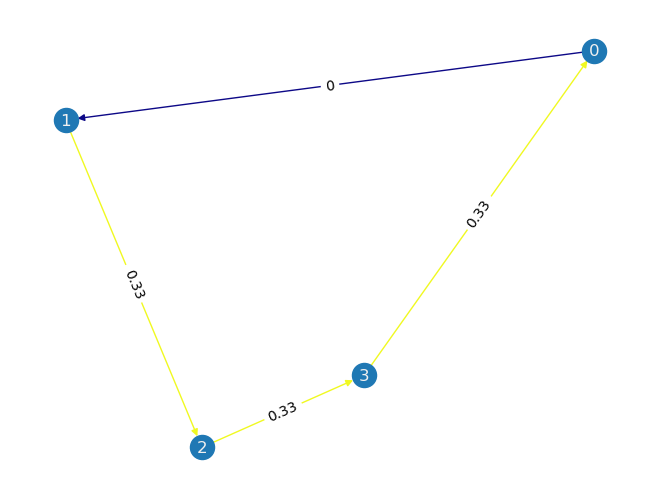

In [59]:
def branch_current_method(G, s, t, e):
    N = len(G)
    
    A = np.zeros((N, N))
    B = np.zeros(N)
    
    V = np.full(N, None)
    V[s] = 0
    V[t] = e
    
    for u in range(N):
        # Out (+I_k)
        for v in [v for v in G.neighbors(u)]:
            w = G[u][v]["weight"]
            if w == 0:
                continue
            
            if V[u] is None: A[u][u] += 1 / w
            else: B[u] -= V[u] / w
            if V[v] is None: A[u][v] -= 1 / w
            else: B[u] += V[v] / w
            
        # In (-I_k)
        for v in range(N):
            if not G.has_edge(v, u) or G[v][u]["weight"] == 0:
                continue
            w = G[v][u]["weight"]
            
            if V[u] is None: A[u][u] += 1 / w
            else: B[u] -= V[u] / w
            if V[v] is None: A[u][v] -= 1 / w
            else: B[u] += V[v] / w
    
    # Remove unnecessary rows and columns, avoiding det(A) = 0
    A = np.delete(A, (s, t), 0)
    A = np.delete(A, (s, t), 1)
    B = np.delete(B, (s, t))
    res = np.linalg.solve(A, B)
    
    # Merge together electric potential differences of s and t nodes with others
    j = 0
    for i in range(N):
        if i == s or i == t: continue
        V[i] = res[j]
        j += 1
    
    # Evaluate electric current in every edge of the circuit
    I = {}
    for i, e in enumerate(G.edges):
        u, v = e
        if G[u][v]["weight"] == 0: I[e] = 0
        else: I[e] = round((V[u] - V[v]) / G[u][v]["weight"], 2)
        
    return I


def draw_graph(G, weights):
    layout = nx.spring_layout(G, seed=213700)
    
    _min, _max = min(weights.values()), max(weights.values())
    edge_color_intesities = []
    for u, v in G.edges:
        edge_color_intesities.append((weights[(u, v)] - _min) / (_max - _min))
    
    nx.draw(G, pos=layout, edge_color=edge_color_intesities, edge_cmap=mpl.colormaps["plasma"])
    nx.draw_networkx_labels(G, pos=layout, font_color="#f0f0f0")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=weights)
    

draw_graph(G, branch_current_method(G, s, t, e))

In [68]:
def add_weights_to_graph(G, s, t):
    G = parse_to_directed(G, s, t)
    
    for u, v in G.edges:
        G.update(edges=[(u, v, {"weight": np.random.rand() * 101})])
    
    return G

C:\Users\Jakub\AppData\Local\Temp\ipykernel_10456\1172683926.py:63: RuntimeWarning: invalid value encountered in double_scalars
  edge_color_intesities.append((weights[(u, v)] - _min) / (_max - _min))


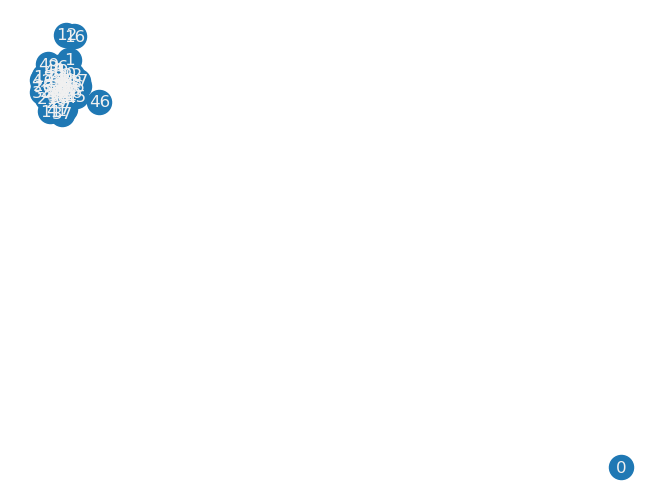

In [71]:
X = add_weights_to_graph(nx.erdos_renyi_graph(50, 0.3), s, t)
draw_graph(X, branch_current_method(X, s, t, e))

In [74]:
X = add_weights_to_graph(nx.random_regular_graph(3, 20), s, t)
draw_graph(X, branch_current_method(X, s, t, e))

LinAlgError: Singular matrix

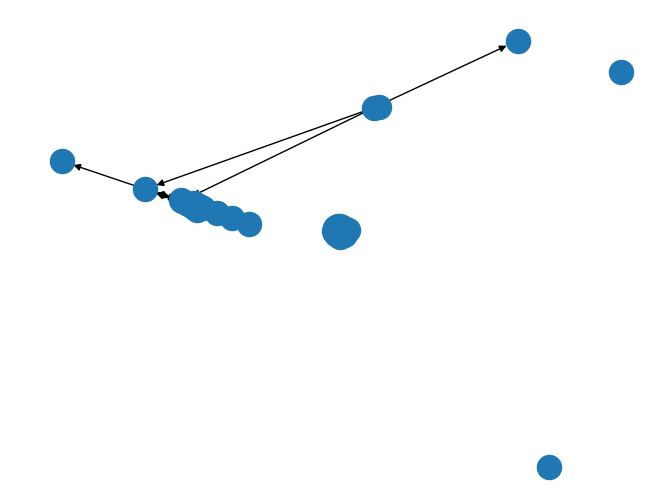

In [79]:
N = 20
G0 = nx.erdos_renyi_graph(N, 0.4)
G1 = nx.erdos_renyi_graph(40, 0.45)
for u, v in [e for e in G1.edges]:
    G1.remove_edge(u, v)
    G1.add_edge(u + N, v + N)
G = add_weights_to_graph(nx.compose(G0, G1), s, t)
nx.draw(G)
# draw_graph(G, branch_current_method(G, s, t, e))